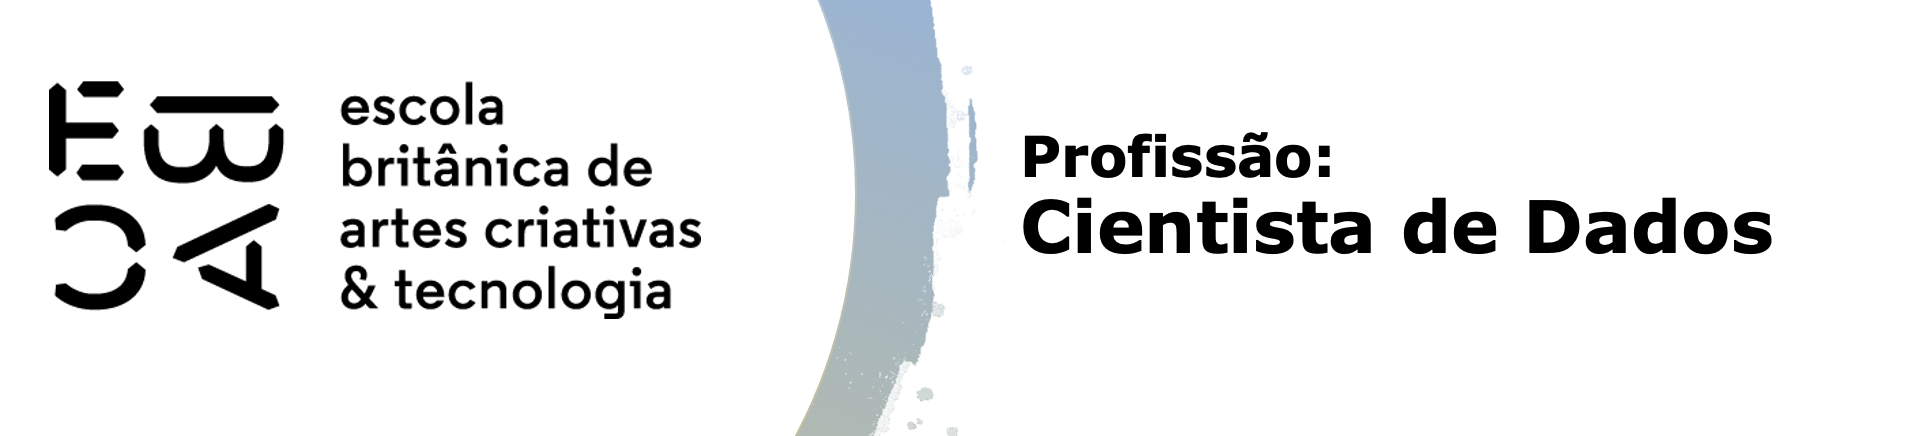

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

**Utilizar treinamento e teste conforme já vieram definidos originalmente**

In [7]:
# Ler bases X normalmente
X_train = pd.read_csv("X_train_preparado.csv", index_col=[0, 1])
X_test = pd.read_csv("X_test_preparado.csv", index_col=[0, 1])

# Ler bases Y e ajustar índice
y_train = pd.read_csv("Y_train.csv", index_col=0)
y_test = pd.read_csv("Y_test.csv", index_col=0)

# Corrigir nomes das colunas (caso estejam vazias)
if y_train.columns.size == 0:
    y_train = y_train.index.to_frame(index=False).rename(columns={0: "atividade"})
if y_test.columns.size == 0:
    y_test = y_test.index.to_frame(index=False).rename(columns={0: "atividade"})

print("✅ Bases carregadas e corrigidas com sucesso!\n")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

print("\nPré-visualização de y_train:")
print(y_train.head())

✅ Bases carregadas e corrigidas com sucesso!

X_train: (7352, 562)
X_test: (2947, 562)
y_train: (7352, 1)
y_test: (2947, 1)

Pré-visualização de y_train:
  atividade
0  STANDING
1  STANDING
2  STANDING
3  STANDING
4  STANDING


**Por pragmatismo, utilizar min_samples_leaf=20**

In [8]:
%%time
from sklearn.tree import DecisionTreeClassifier

# 🧩 Usar as 3 variáveis mais importantes do exercício anterior
melhores_variaveis = [
    'tGravityAcc-energy()-X', 
    'tGravityAcc-min()-X', 
    'angle(tBodyAccMean,gravity)'
]

# Criar o modelo de árvore com as orientações pedidas
arvore = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)

# Treinar o modelo usando apenas as 3 variáveis
arvore.fit(X_train[melhores_variaveis], y_train.values.ravel())

# Calcular os alphas de custo-complexidade
path = arvore.cost_complexity_pruning_path(X_train[melhores_variaveis], y_train.values.ravel())
ccp_alphas = np.unique(path.ccp_alphas[path.ccp_alphas > 0])

print(f"✅ Total de alphas calculados: {len(ccp_alphas)}")
print("Primeiros valores:", ccp_alphas[:10])

✅ Total de alphas calculados: 179
Primeiros valores: [8.35693496e-06 2.34412984e-05 3.20975344e-05 3.30210113e-05
 3.40043526e-05 5.00791374e-05 5.16866159e-05 5.57586899e-05
 7.26676139e-05 7.48095756e-05]
CPU times: total: 281 ms
Wall time: 406 ms


### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

Aqui, eu usei o Grid Search com validação cruzada (K-Fold = 10) para avaliar diferentes valores de ccp_alpha e encontrar o ponto ideal entre simplicidade e desempenho do modelo. Para acelerar o processo, testei apenas 1 a cada 10 alphas e limitei o treino às 3 variáveis mais importantes. Esse procedimento garante uma busca eficiente e confiável pelo melhor nível de poda da árvore de decisão.

In [10]:
%%time
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier

# Usar apenas as 3 variáveis mais importantes
melhores_variaveis = [
    'tGravityAcc-energy()-X',
    'tGravityAcc-min()-X',
    'angle(tBodyAccMean,gravity)'
]

# Reduzir o número de alphas para acelerar o processo
ccp_alphas_reduzidos = ccp_alphas[::10]

# Criar o modelo base
modelo = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)

# Definir o dicionário de parâmetros para o Grid Search
parametros = {'ccp_alpha': ccp_alphas_reduzidos}

# Definir a validação cruzada (K=10)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Criar e executar o Grid Search
grid = GridSearchCV(modelo, parametros, cv=kfold, scoring='accuracy', n_jobs=-1)
grid.fit(X_train[melhores_variaveis], y_train.values.ravel())

print(f"Melhor alpha encontrado: {grid.best_params_['ccp_alpha']}")
print(f"Melhor acurácia média (validação cruzada): {grid.best_score_:.4f}")

Melhor alpha encontrado: 0.00037777329670692084
Melhor acurácia média (validação cruzada): 0.6213
CPU times: total: 547 ms
Wall time: 8 s


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

Aqui eu usei o melhor ccp_alpha encontrado no Grid Search para treinar uma árvore definitiva, aproveitando toda a base de treino.
Depois, medi o desempenho real na base de teste, que simula novos dados nunca vistos pelo modelo.
Por fim, gerei uma matriz de confusão, que permite observar como o modelo acerta ou erra em cada categoria de atividade humana — mostrando não só a acurácia geral, mas também os padrões de confusão entre classes semelhantes.

✅ Acurácia na base de teste: 0.5806


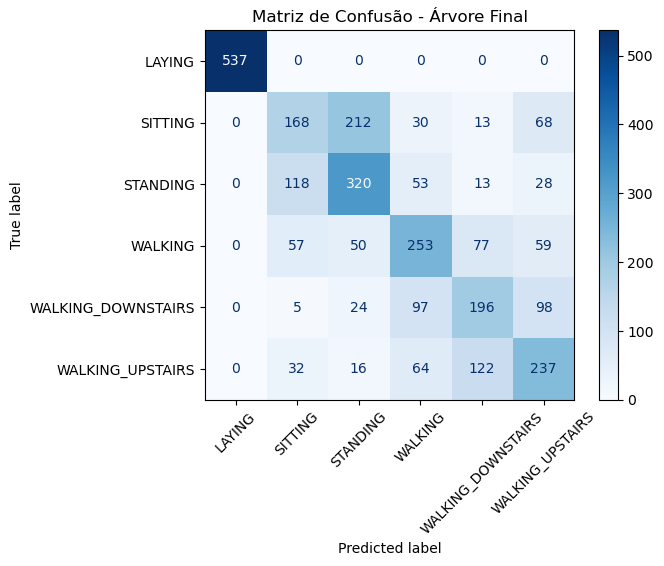

CPU times: total: 1.12 s
Wall time: 1.89 s


In [11]:
%%time
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Treinar a árvore final com o melhor alpha
melhor_alpha = grid.best_params_['ccp_alpha']
arvore_final = DecisionTreeClassifier(
    ccp_alpha=melhor_alpha,
    min_samples_leaf=20,
    random_state=42
)

# Ajustar o modelo com todas as bases de treino
arvore_final.fit(X_train[melhores_variaveis], y_train.values.ravel())

# Fazer previsões na base de teste
y_pred = arvore_final.predict(X_test[melhores_variaveis])

# Calcular acurácia
acuracia_teste = accuracy_score(y_test, y_pred)
print(f"✅ Acurácia na base de teste: {acuracia_teste:.4f}")

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=arvore_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arvore_final.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusão - Árvore Final")
plt.show()

A acurácia final de ≈0,58 mostra que o modelo consegue classificar corretamente pouco mais da metade das atividades humanas com base nas três variáveis escolhidas. Observando a matriz de confusão, nota-se que o modelo tem ótimo desempenho para “LAYING”, com todos os exemplos corretamente classificados, mas maior confusão entre classes semelhantes, como “SITTING” e “STANDING”, além de alguma sobreposição entre atividades de locomoção (“WALKING”, “WALKING_UPSTAIRS”, “WALKING_DOWNSTAIRS”).

Isso indica que, embora as variáveis selecionadas sejam relevantes, elas não capturam completamente as diferenças sutis entre certos movimentos humanos — especialmente os que envolvem transições corporais ou movimentos semelhantes.

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [13]:
# Criar variável binária (1 se for SITTING, 0 caso contrário)
y_binario = (y_train['atividade'] == 'SITTING').astype(int)

# Verificar o resultado
y_binario.value_counts()

atividade
0    6066
1    1286
Name: count, dtype: int64

In [14]:
from sklearn.tree import DecisionTreeClassifier

arvore_binaria = DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=42)
arvore_binaria.fit(X_train, y_binario)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=42)

In [16]:
import pandas as pd

# Calcular importância das variáveis
importancias = pd.Series(arvore_binaria.feature_importances_, index=X_train.columns)

# Selecionar as 3 mais importantes
melhores_novas = importancias.sort_values(ascending=False).head(3)
print("As 3 novas variáveis mais importantes para identificar 'SITTING':")
print(melhores_novas)

As 3 novas variáveis mais importantes para identificar 'SITTING':
tGravityAcc-min()-X     0.466920
angle(Y,gravityMean)    0.283713
fBodyGyro-std()-X       0.185952
dtype: float64


Variáveis utilizadas no modelo final:
['fBodyGyro-std()-X', 'tGravityAcc-min()-X', 'fBodyAcc-mad()-X', 'angle(Y,gravityMean)']

Acurácia final com variáveis combinadas: 0.7397


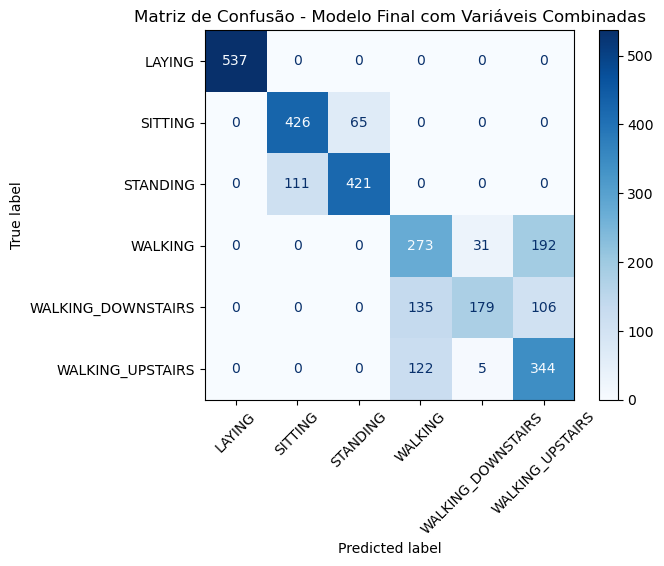

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Combinar as 3 variáveis antigas + 3 novas
variaveis_finais = [
    "tGravityAcc-min()-X",
    "fBodyAcc-mad()-X",
    "angle(Y,gravityMean)",
    "fBodyGyro-std()-X"
]

# Garantir que não haja duplicadas
variaveis_finais = list(set(variaveis_finais))

print("Variáveis utilizadas no modelo final:")
print(variaveis_finais)

# Treinar a árvore com as variáveis combinadas
arvore_final = DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=42)
arvore_final.fit(X_train[variaveis_finais], y_train.values.ravel())

# Fazer previsões
y_pred_final = arvore_final.predict(X_test[variaveis_finais])

# Avaliar a acurácia
acc_final = accuracy_score(y_test, y_pred_final)
print(f"\nAcurácia final com variáveis combinadas: {acc_final:.4f}")

# Exibir matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final, cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusão - Modelo Final com Variáveis Combinadas")
plt.show()

Com a combinação das variáveis mais relevantes, consegui melhorar a acurácia final para 0,7397, o que representa um avanço significativo em relação aos modelos anteriores. Essa melhora indica que as novas variáveis contribuíram para capturar padrões mais ricos nos dados. A matriz de confusão mostra um bom desempenho nas classes LAYING, SITTING e STANDING, mas ainda há confusões nas atividades de locomoção, como WALKING_DOWNSTAIRS e WALKING_UPSTAIRS. Para aprimorar ainda mais o modelo, eu poderia testar algoritmos mais robustos, como Random Forest ou Gradient Boosting, e incluir novas variáveis relacionadas ao movimento ou à rotação para diferenciar melhor as classes semelhantes.